# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

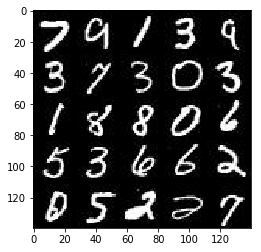

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

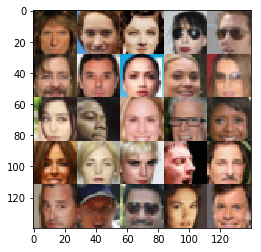

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [35]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    z = tf.placeholder(tf.float32, (None, z_dim), name ='input_z')
    lr = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs_real, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [36]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        #Input layer
        x1 = tf.layers.conv2d(inputs = images, filters = 64, kernel_size = 5, 
                              strides = 2, padding = 'same')
        #Leaky ReLU
        x1 = tf.maximum(alpha * x1, x1)
        
        #Second layer
        x2 = tf.layers.conv2d(inputs = x1, filters = 128, kernel_size = 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        #Activate LReLU
        x2 = tf.maximum(alpha * x2, x2)
        
        #Third layer
        x3 = tf.layers.conv2d(inputs = x2, filters = 256, kernel_size = 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        #Activate LReLU
        x3 = tf.maximum(alpha * x3, x3)
        
        #Flattening
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        
        #Fully connected layer, depth 512
        x1 = tf.layers.dense(z, 2*2*512)
        #Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        #LReLU
        x1 = tf.maximum(alpha*x1, x1)
        
        #Second layer, depth 256
        x2 = tf.layers.conv2d_transpose(inputs = x1, filters = 256, kernel_size = 5, strides = 2, padding = 'valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        #LReLU
        x2 = tf.maximum(alpha*x2, x2)
        
        #Third layer, depth 128
        x3 = tf.layers.conv2d_transpose(inputs = x2, filters = 128, kernel_size = 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        #LReLU
        x3 = tf.maximum(alpha*x3, x3)
        
        #Last layer as logits
        logits = tf.layers.conv2d_transpose(inputs = x3, filters = out_channel_dim, kernel_size = 5, strides = 2, padding = 'same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
 
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
        labels=tf.ones_like(d_model_real)*smooth))
 
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake,
        labels = tf.zeros_like(d_model_fake)))
 
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake,
        labels = tf.ones_like(d_model_fake)))
 
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
 
    # Optimise
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
 
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_vars)
 
    # Discriminator/generator training operations
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    inputs_real, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0 

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
            
            # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

            # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, z, data_shape[3], data_image_mode)
                    #show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)''' 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 8.0921
Epoch 1/2... Discriminator Loss: 3.4330... Generator Loss: 6.6109
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 0.9333
Epoch 1/2... Discriminator Loss: 0.4694... Generator Loss: 3.0123
Epoch 1/2... Discriminator Loss: 0.8444... Generator Loss: 1.9929
Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 1.9796
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 3.2023
Epoch 1/2... Discriminator Loss: 0.6206... Generator Loss: 2.4131
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 2.3510
Epoch 1/2... Discriminator Loss: 0.5069... Generator Loss: 2.3519


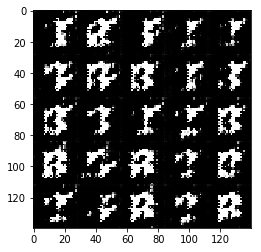

Epoch 1/2... Discriminator Loss: 0.6301... Generator Loss: 3.0502
Epoch 1/2... Discriminator Loss: 0.7331... Generator Loss: 3.2620
Epoch 1/2... Discriminator Loss: 1.6571... Generator Loss: 0.7428
Epoch 1/2... Discriminator Loss: 0.4904... Generator Loss: 3.3965
Epoch 1/2... Discriminator Loss: 0.8178... Generator Loss: 1.6083
Epoch 1/2... Discriminator Loss: 0.5889... Generator Loss: 3.4287
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 2.1268
Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 1.5562
Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 1.6065
Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 1.9592


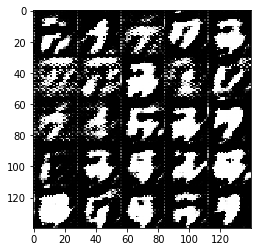

Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 1.2273
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 1.0181
Epoch 1/2... Discriminator Loss: 0.9569... Generator Loss: 2.3910
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 0.5856... Generator Loss: 2.7301
Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 1.2646
Epoch 1/2... Discriminator Loss: 0.6908... Generator Loss: 2.0734
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 1.5634
Epoch 1/2... Discriminator Loss: 0.9715... Generator Loss: 0.9843


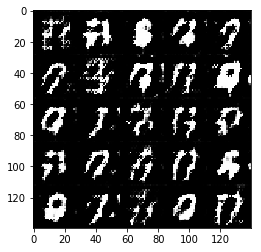

Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 1.0737
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 1.8509
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 1.3434
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.3995
Epoch 1/2... Discriminator Loss: 1.4671... Generator Loss: 4.0988
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 2.8839
Epoch 1/2... Discriminator Loss: 0.8171... Generator Loss: 2.0331
Epoch 1/2... Discriminator Loss: 0.8708... Generator Loss: 1.2850
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 2.1874


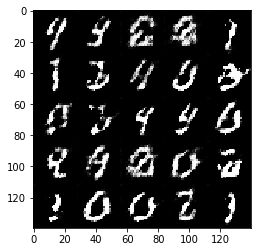

Epoch 1/2... Discriminator Loss: 1.0747... Generator Loss: 1.8782
Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 0.9531
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 1.0203
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 1.1754
Epoch 1/2... Discriminator Loss: 1.2073... Generator Loss: 0.7247
Epoch 1/2... Discriminator Loss: 1.5939... Generator Loss: 0.5315
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 1.4755
Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 1.3171
Epoch 1/2... Discriminator Loss: 1.5807... Generator Loss: 0.4172


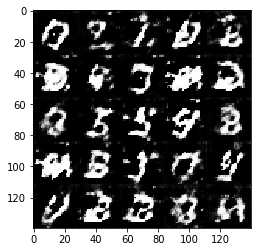

Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.2878
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 1.0724
Epoch 1/2... Discriminator Loss: 1.5722... Generator Loss: 1.2976
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.6139
Epoch 1/2... Discriminator Loss: 1.9983... Generator Loss: 3.4957
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 1.3370
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.8449
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.7443
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.5118


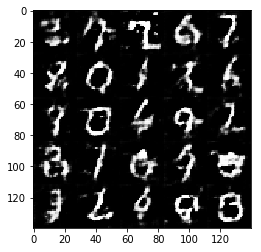

Epoch 1/2... Discriminator Loss: 1.0354... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.8576
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.1668
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 1.0060
Epoch 1/2... Discriminator Loss: 0.9831... Generator Loss: 0.8987
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 1.1059
Epoch 1/2... Discriminator Loss: 1.0494... Generator Loss: 1.4333
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 2.1346... Generator Loss: 4.2007


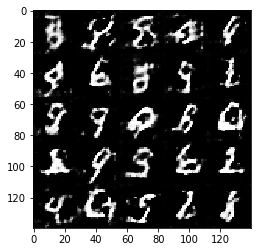

Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 2.0622
Epoch 1/2... Discriminator Loss: 1.4262... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.9515
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 1.5725
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 2.3380
Epoch 1/2... Discriminator Loss: 1.4337... Generator Loss: 0.5211
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 0.8212
Epoch 1/2... Discriminator Loss: 0.9889... Generator Loss: 1.0162
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 1.2664... Generator Loss: 0.6355


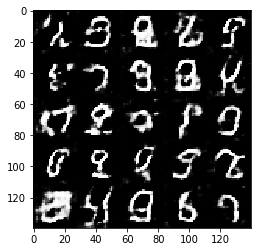

Epoch 1/2... Discriminator Loss: 1.0206... Generator Loss: 1.2406
Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 1.6968
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.6747... Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.9754
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 0.8202


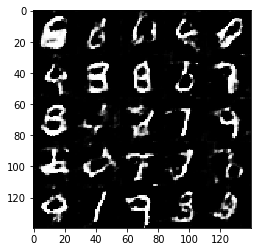

Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 1.3967
Epoch 1/2... Discriminator Loss: 1.0260... Generator Loss: 1.9184
Epoch 1/2... Discriminator Loss: 0.8375... Generator Loss: 1.7061
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.7284
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.5101
Epoch 1/2... Discriminator Loss: 2.6768... Generator Loss: 0.1795
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.8566
Epoch 1/2... Discriminator Loss: 0.9058... Generator Loss: 1.1447
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.6843


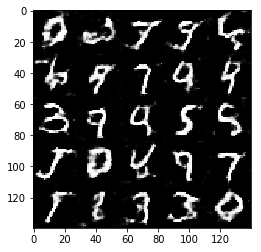

Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 0.9220
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.6997
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 0.9554
Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 1.3732
Epoch 1/2... Discriminator Loss: 1.1060... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 1.1900... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 0.9335
Epoch 1/2... Discriminator Loss: 1.5243... Generator Loss: 0.4494
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 1.9623


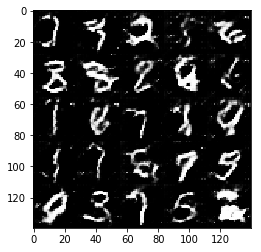

Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 1.0035
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 0.9454
Epoch 1/2... Discriminator Loss: 1.7451... Generator Loss: 0.4073
Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 1.3918
Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 2.2637
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 2.1262
Epoch 1/2... Discriminator Loss: 1.0492... Generator Loss: 1.3668
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 0.7794
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 0.9755


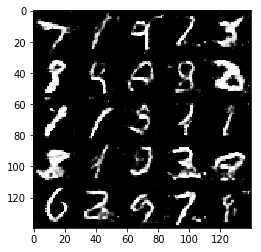

Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 2.0699... Generator Loss: 0.2565
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 0.9657... Generator Loss: 0.9988
Epoch 1/2... Discriminator Loss: 2.3439... Generator Loss: 0.1994
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 1.4692
Epoch 1/2... Discriminator Loss: 0.9541... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 2.5838
Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 0.8788


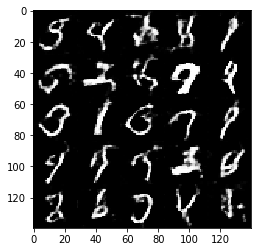

Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 1.5704
Epoch 1/2... Discriminator Loss: 0.9355... Generator Loss: 1.2669
Epoch 1/2... Discriminator Loss: 1.5950... Generator Loss: 0.4438
Epoch 1/2... Discriminator Loss: 0.9145... Generator Loss: 1.1674
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.0766... Generator Loss: 1.0130
Epoch 1/2... Discriminator Loss: 0.8618... Generator Loss: 2.3415
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 1.0656


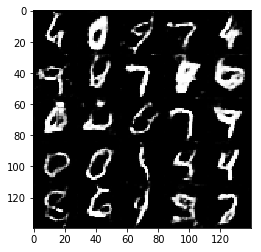

Epoch 1/2... Discriminator Loss: 0.9459... Generator Loss: 2.1396
Epoch 1/2... Discriminator Loss: 0.7248... Generator Loss: 1.9979
Epoch 1/2... Discriminator Loss: 1.6432... Generator Loss: 2.5766
Epoch 1/2... Discriminator Loss: 2.1589... Generator Loss: 0.2364
Epoch 1/2... Discriminator Loss: 1.0992... Generator Loss: 0.7927
Epoch 1/2... Discriminator Loss: 0.8942... Generator Loss: 1.4998
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 2.2054
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 0.8959
Epoch 1/2... Discriminator Loss: 2.0010... Generator Loss: 0.2599
Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 0.5239


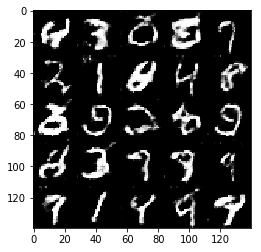

Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 2.0573
Epoch 1/2... Discriminator Loss: 1.7031... Generator Loss: 0.4132
Epoch 1/2... Discriminator Loss: 2.2798... Generator Loss: 0.2253
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 0.8566... Generator Loss: 1.1535
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 2.1035
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 1.2952
Epoch 1/2... Discriminator Loss: 0.7741... Generator Loss: 1.2852
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 1.2052


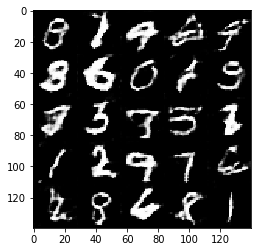

Epoch 1/2... Discriminator Loss: 1.4388... Generator Loss: 1.6627
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 0.9751
Epoch 1/2... Discriminator Loss: 1.4233... Generator Loss: 0.5508
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 1.1690
Epoch 1/2... Discriminator Loss: 0.8874... Generator Loss: 1.1695
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 1.2729... Generator Loss: 0.6571
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 2.1258
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.6437


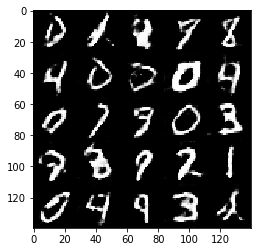

Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 1.6406
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 1.2524
Epoch 1/2... Discriminator Loss: 0.9155... Generator Loss: 1.8664
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.7853... Generator Loss: 0.3268
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 3.1007
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 3.2663
Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.6061


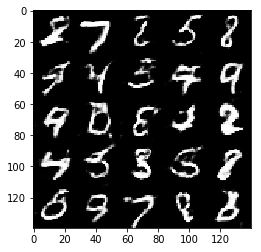

Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 1.0599
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.8162
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 2.1338... Generator Loss: 0.3606
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 0.8742
Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 0.7143
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.9057
Epoch 2/2... Discriminator Loss: 2.0212... Generator Loss: 0.2959
Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 1.1695
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.1097
Epoch 2/2... Discriminator Loss: 1.4507... Generator Loss: 0.5555
Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 1.7981
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 3.5326
Epoch 2/2.

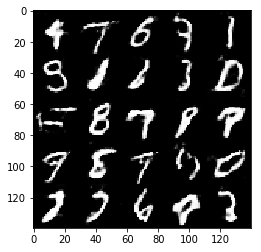

Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 1.8654
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.3287
Epoch 2/2... Discriminator Loss: 1.9559... Generator Loss: 0.3325
Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 1.0415
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.7439
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 0.8909... Generator Loss: 1.6982
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 1.3478


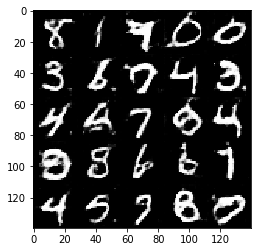

Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.6604
Epoch 2/2... Discriminator Loss: 0.7524... Generator Loss: 1.5507
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 1.1515
Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 1.6966
Epoch 2/2... Discriminator Loss: 1.0356... Generator Loss: 0.9271
Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 3.8076
Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 1.2233
Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 1.5073
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 0.9706


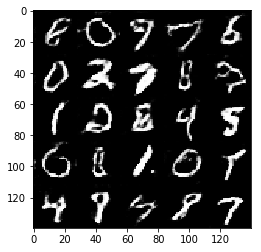

Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 1.1027
Epoch 2/2... Discriminator Loss: 1.3245... Generator Loss: 0.6405
Epoch 2/2... Discriminator Loss: 1.5705... Generator Loss: 0.5667
Epoch 2/2... Discriminator Loss: 1.4830... Generator Loss: 0.5590
Epoch 2/2... Discriminator Loss: 0.9163... Generator Loss: 1.4625
Epoch 2/2... Discriminator Loss: 0.6055... Generator Loss: 2.1331
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 2.6429
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 1.7081
Epoch 2/2... Discriminator Loss: 0.6597... Generator Loss: 1.6320
Epoch 2/2... Discriminator Loss: 1.8502... Generator Loss: 0.3719


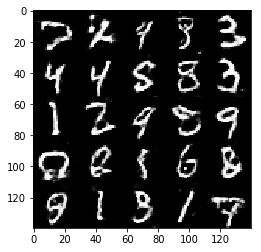

Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 1.9460
Epoch 2/2... Discriminator Loss: 2.2899... Generator Loss: 0.2133
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 3.0578
Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 1.1966
Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 1.2747
Epoch 2/2... Discriminator Loss: 1.6159... Generator Loss: 0.4406
Epoch 2/2... Discriminator Loss: 2.6408... Generator Loss: 0.1452
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 1.2245
Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 0.6748
Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 1.0202


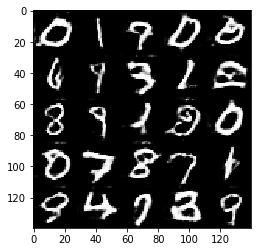

Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.9226
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 1.2606
Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 1.3814
Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 0.8704... Generator Loss: 2.8683
Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 1.5742
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 1.7378
Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 2.6844
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.6635


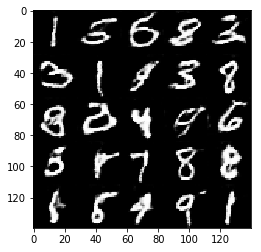

Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 1.7709
Epoch 2/2... Discriminator Loss: 1.0920... Generator Loss: 1.5702
Epoch 2/2... Discriminator Loss: 0.6749... Generator Loss: 1.7155
Epoch 2/2... Discriminator Loss: 1.4642... Generator Loss: 0.6232
Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 1.3942
Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 1.4695
Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.7137
Epoch 2/2... Discriminator Loss: 0.7457... Generator Loss: 2.8826
Epoch 2/2... Discriminator Loss: 0.6756... Generator Loss: 2.3981
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 2.2894


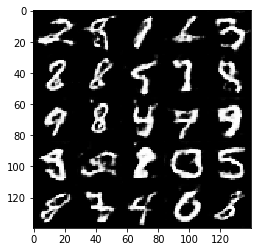

Epoch 2/2... Discriminator Loss: 0.7281... Generator Loss: 1.4595
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 2.5152
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.2104
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 1.4475
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 1.4268
Epoch 2/2... Discriminator Loss: 1.7623... Generator Loss: 0.3622
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 1.4932


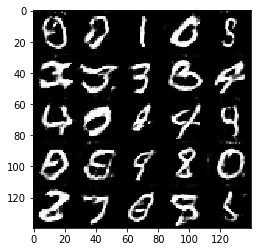

Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.3014
Epoch 2/2... Discriminator Loss: 0.8276... Generator Loss: 1.7922
Epoch 2/2... Discriminator Loss: 1.5958... Generator Loss: 0.4799
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.0137
Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 2.2565
Epoch 2/2... Discriminator Loss: 1.6195... Generator Loss: 0.4684
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.6958
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 2.3052
Epoch 2/2... Discriminator Loss: 1.1074... Generator Loss: 0.7552
Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.9465


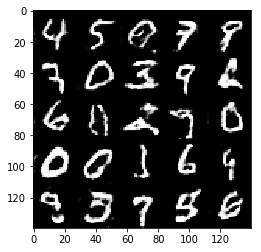

Epoch 2/2... Discriminator Loss: 0.8950... Generator Loss: 1.4549
Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.1435
Epoch 2/2... Discriminator Loss: 0.8429... Generator Loss: 1.3386
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 1.0106
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 1.0626... Generator Loss: 1.3142
Epoch 2/2... Discriminator Loss: 0.7140... Generator Loss: 2.6693
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 2.6037
Epoch 2/2... Discriminator Loss: 2.2044... Generator Loss: 0.3038
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 0.9012


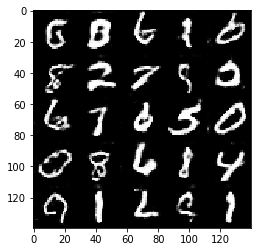

Epoch 2/2... Discriminator Loss: 0.7098... Generator Loss: 1.6447
Epoch 2/2... Discriminator Loss: 0.8696... Generator Loss: 1.2895
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 1.2942
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 2.0478
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.7182
Epoch 2/2... Discriminator Loss: 1.0424... Generator Loss: 0.9262
Epoch 2/2... Discriminator Loss: 2.2865... Generator Loss: 0.2699
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 2.0441
Epoch 2/2... Discriminator Loss: 0.9837... Generator Loss: 1.6601


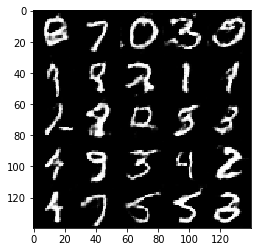

Epoch 2/2... Discriminator Loss: 1.8012... Generator Loss: 0.4148


KeyboardInterrupt: 

In [42]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 11.6558
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 13.2481
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.1719
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 15.5454
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 9.9394
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 12.5867
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 6.4064
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 3.7353
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 2.6977


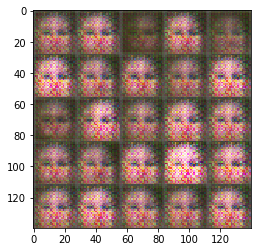

Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.7191
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 4.0396
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 2.7313
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 4.8798
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.8830


In [47]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.